
--- Starting Validation ---
Validation Episode 1: Total Reward = 1027.2
Validation Episode 2: Total Reward = 1024.2
Validation Episode 3: Total Reward = 1001.2
Validation Episode 4: Total Reward = 1042.5
Validation Episode 5: Total Reward = 991.0
Validation Episode 6: Total Reward = 985.5
Validation Episode 7: Total Reward = 1017.0
Validation Episode 8: Total Reward = 1033.0
Validation Episode 9: Total Reward = 1022.8
Validation Episode 10: Total Reward = 1001.0
Generating animation with 306 frames...
Saving to validation_run-0.gif (this might take a minute)...
Success! Saved to validation_run-0.gif
[ 1  2  3  4  5  6  7  8  9 10]
[1027.2, 1024.2, 1001.1999999999999, 1042.5, 991.0, 985.5, 1017.0, 1033.0, 1022.8, 1001.0]

Validation #0 Finished. Average Reward: 1014.5

--- Starting Validation ---
Validation Episode 1: Total Reward = 1020.9
Validation Episode 2: Total Reward = 1032.1
Validation Episode 3: Total Reward = 1029.1
Validation Episode 4: Total Reward = 992.2
Validation Episod

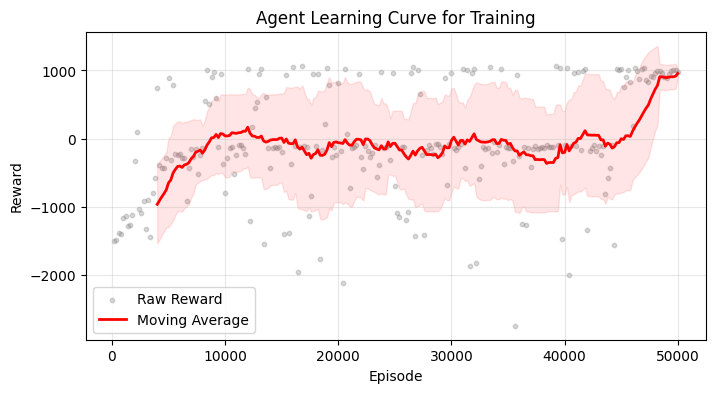

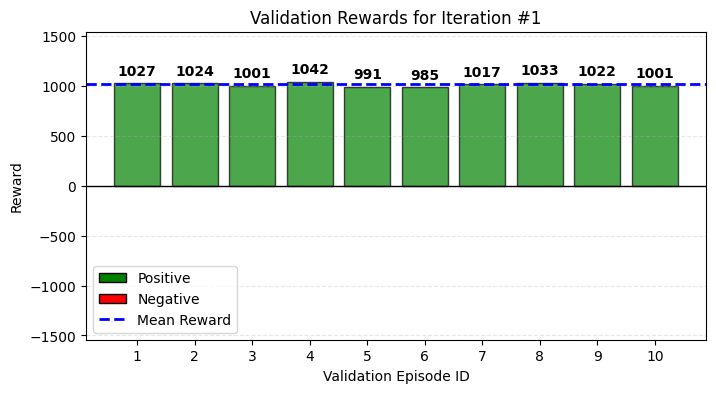

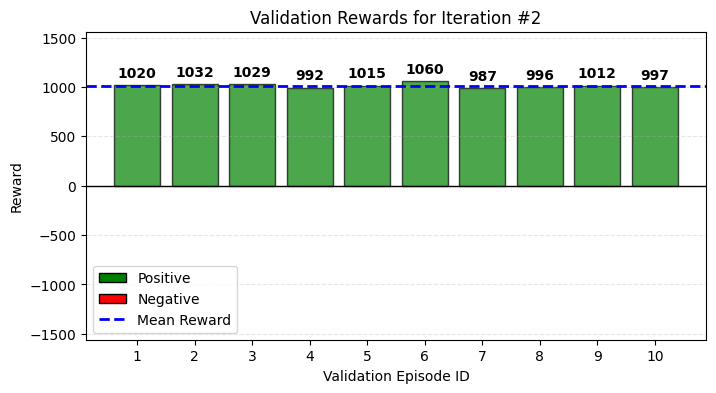

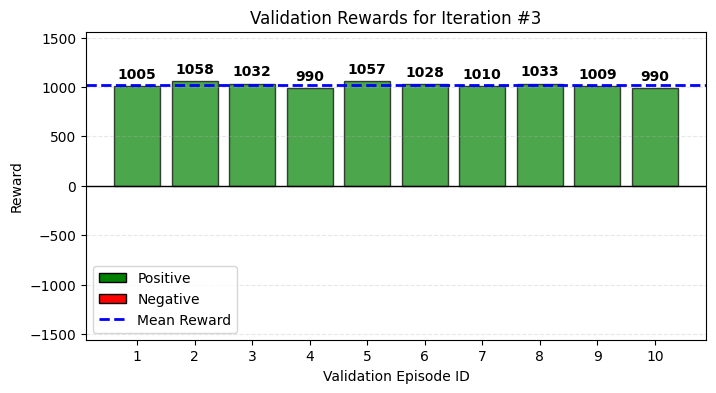

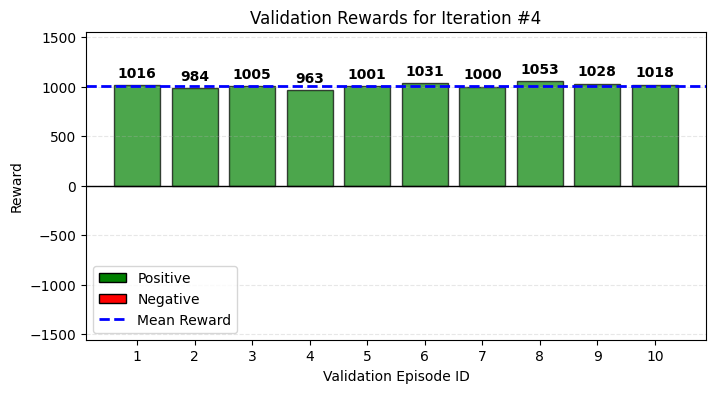

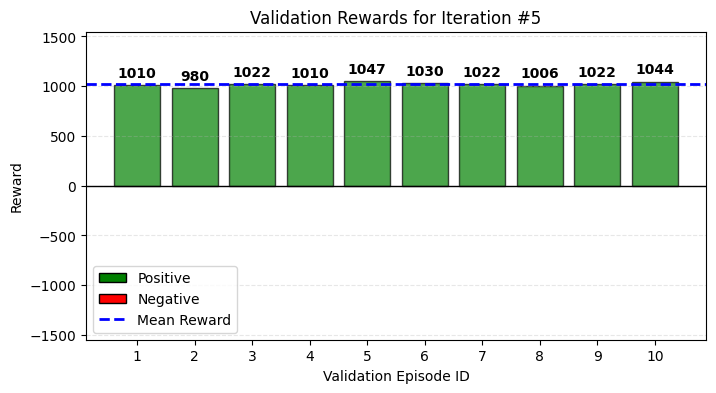

In [35]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Patch
import os
from irrigation_environment import IrrigationEnv

def animate_training_progression(all_grids, log_interval=1000, save_path="training_progression.gif", label="Training"):    
    all_frames = []
    episode_labels = []    
    for i, episode_frames in enumerate(all_grids):
        episode_num = (i + 1) * log_interval
        for frame in episode_frames:
            all_frames.append(frame)
            episode_labels.append(f"{label} Episode: {episode_num}")
    if len(all_frames) == 0:
        print("No frames found to animate.")
        return
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.axis('off')
    im = ax.imshow(all_frames[0])
    title = ax.set_title(episode_labels[0])
    def update(frame_idx):
        im.set_array(all_frames[frame_idx])
        title.set_text(episode_labels[frame_idx])
        return [im, title]
    print(f"Generating animation with {len(all_frames)} frames...")
    ani = animation.FuncAnimation(
        fig, update, frames=len(all_frames), interval=50, blit=False
    )
    
    try:
        print(f"Saving to {save_path} (this might take a minute)...")
        ani.save(save_path, writer='pillow', fps=15)
        print(f"Success! Saved to {save_path}")
    except Exception as e:
        print(f"Error saving animation: {e}")
    finally:
        plt.close(fig)

def plot_all_training(csv_file="training_log.csv"):
    episodes = []
    rewards = []
    window_size = 20
    with open(csv_file, "r") as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if len(row) >= 2:
                episodes.append(int(row[0]))  
                rewards.append(float(row[1]))

    df = pd.DataFrame({'Episode': episodes, 'Reward': rewards})    
    df['Moving_Avg'] = df['Reward'].rolling(window=window_size).mean()
    df['Std_Dev'] = df['Reward'].rolling(window=window_size).std()
    
    plt.figure(figsize=(8, 4))    
    plt.scatter(df['Episode'], df['Reward'], color='gray', alpha=0.3, s=10, label='Raw Reward')    
    plt.plot(df['Episode'], df['Moving_Avg'], color='red', linewidth=2, label='Moving Average')    
    plt.fill_between(df['Episode'], 
                     df['Moving_Avg'] - df['Std_Dev'], 
                     df['Moving_Avg'] + df['Std_Dev'], 
                     color='red', alpha=0.1) 
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Agent Learning Curve for Training")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('training_sma_plot.jpg', format='jpg', dpi=300, bbox_inches='tight')
    
def plot_validation(rewards = [], iteration = 1):
    episodes = np.arange(1, len(rewards) + 1)
    rewards = rewards
    print(episodes)
    print(rewards)
    
    mean_reward = np.mean(rewards)
    
    colors = ['red' if r < 0 else 'green' for r in rewards]

    plt.figure(figsize=(8, 4))
    bars = plt.bar(episodes, rewards, color=colors, edgecolor='black', alpha=0.7)
    plt.axhline(0, color='black', linewidth=1) # The Zero Line
    plt.axhline(mean_reward, color='blue', linestyle='--', linewidth=2, label=f'Mean: {mean_reward:.1f}')
    
    for bar in bars:
        height = bar.get_height()
        label_y_pos = height + 50 if height > 0 else height - 150
        vert_align = 'bottom' if height > 0 else 'top'
        
        plt.text(bar.get_x() + bar.get_width()/2, label_y_pos, 
                 f'{int(height)}', ha='center', va=vert_align, fontweight='bold')
    
    plt.xticks(episodes)
    plt.xlabel("Validation Episode ID")
    plt.ylabel("Reward")
    plt.title(f"Validation Rewards for Iteration #{iteration}")
    
    legend_elements = [
        Patch(facecolor='green', edgecolor='black', label='Positive'),
        Patch(facecolor='red', edgecolor='black', label='Negative'),
        plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Reward')
    ]
    plt.legend(handles=legend_elements)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    limit = max(abs(min(rewards)), abs(max(rewards))) + 500
    plt.ylim(-limit, limit)
    
    plt.savefig(f'validation_plot_{iteration}.jpg', format='jpg', dpi=300, bbox_inches='tight')

def train_agent():
    # --- Hyperparameters ---
    total_episodes = 50000        
    max_steps = 600         
    learning_rate = 0.15          
    discount_rate = 0.99         
    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    decay_rate = 0.0005           
    log_interval = 200   
    log_animation = 10000     
    
    env = IrrigationEnv()
    
    action_size = env.action_space.n
    state_size = env.observation_space.n
    qtable = np.zeros((state_size, action_size))
    grids = [] 
    log_filename = "training_log.csv"
    
    with open(log_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Episode", "Total Reward", "Steps", "Epsilon"])

    print(f"Starting Training: Total - {total_episodes}")
    
    for episode in range(total_episodes):
        state, info = env.reset()
        total_rewards = 0
        terminated = False
        is_logging_episode = (episode + 1) % log_interval == 0
        is_animating = (episode + 1) % log_animation == 0
        episode_grids = []

        for step in range(max_steps):
            action_mask = info["action_mask"]  
            exp_exp_tradeoff = np.random.uniform(0, 1)

            if exp_exp_tradeoff > epsilon:
                # Exploitation
                masked_q_values = qtable[state, :].copy()
                masked_q_values[action_mask == 0] = -np.inf                 
                max_q = np.max(masked_q_values)
                best_actions = np.flatnonzero(masked_q_values == max_q)
                action = np.random.choice(best_actions)
            else:
                # Exploration
                valid_actions = np.flatnonzero(action_mask == 1)
                if len(valid_actions) > 0:
                    action = np.random.choice(valid_actions)
                else:
                    action = env.action_space.sample() 
            
            new_state, reward, terminated, _, info = env.step(action)
            
            next_action_mask = info["action_mask"]
            masked_next_q = qtable[new_state, :].copy()
            masked_next_q[next_action_mask == 0] = -np.inf
            
            target_q = reward + discount_rate * np.max(masked_next_q)
            qtable[state, action] += learning_rate * (target_q - qtable[state, action])
            
            total_rewards += reward
            state = new_state
            
            if is_animating:
                current_grid = env.render()
                episode_grids.append(current_grid)
            if terminated:
                break
                
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        
        if is_logging_episode:
            print(f"Episode {episode + 1}: Reward: {total_rewards:.1f}, Epsilon: {epsilon:.4f}")
            grids.append(episode_grids)
            with open(log_filename, mode="a", newline="") as file:
                writer = csv.writer(file)
                writer.writerow([episode + 1, total_rewards, step, epsilon])
    
    print("Training Finished.")
    return (qtable, grids, log_interval, log_animation)

def validate_agent(qtable, num_episodes=5):
    print("\n--- Starting Validation ---")
    env = IrrigationEnv()
    max_steps = 400
    total_test_rewards = []
    validation_grids = []

    for episode in range(num_episodes):
        state, info = env.reset()
        episode_reward = 0
        terminated = False
        episode_grids = []

        for step in range(max_steps):
            action_mask = info["action_mask"]
            masked_q_values = qtable[state, :].copy()
            masked_q_values[action_mask == 0] = -np.inf
            max_q = np.max(masked_q_values)
            best_actions = np.flatnonzero(masked_q_values == max_q)
            action = np.random.choice(best_actions)
            
            new_state, reward, terminated, _, info = env.step(action)
            episode_reward += reward
            state = new_state
            
            curr_grid = env.render()
            episode_grids.append(curr_grid)
            if terminated:
                break
                
        total_test_rewards.append(episode_reward)
        print(f"Validation Episode {episode + 1}: Total Reward = {episode_reward:.1f}")
        validation_grids.append(episode_grids)
        
    avg_reward = np.mean(total_test_rewards)
    
    return (avg_reward, validation_grids, total_test_rewards)


#qtable, train_grids, log_int, log_animation = train_agent()
#animate_training_progression(train_grids, log_interval=log_animation, save_path=f"test-run.gif", label="Test")
plot_all_training()

for i in range(5):
    avg_reward, val_grids, total_test_rewards = validate_agent(qtable, num_episodes=10)
    animate_training_progression(val_grids, log_interval=1, save_path=f"validation_run-{i}.gif", label="Validation")
    label = f"Rewards for Validation {i+1}"
    plot_validation(rewards=total_test_rewards, iteration=i+1)
    print(f"\nValidation #{i} Finished. Average Reward: {avg_reward:.1f}")
        
